### Llamado de las librerías

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#Creación de modelo
import statsmodels.api as sm
#from sklearn.linear_model import LinearRegression

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Funciones externas
# ==============================================================================
from funciones import multiple_plot, plot_roc_curve, tidy_corr_matrix, checkVIF

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

### Funciones

In [2]:
# Función para contruir un modelo de regresión lineal

def build_model(X,y):

    X = sm.add_constant(X)

    #Se crea y se entrena el modelo de regresion lineal q(statsmodels.api) con
    #los datos de entrada 'X' y los datos de salida 'y'
    lm = sm.OLS(y,X).fit()

    print(lm.summary())

    return X

### Cargue del dataset

In [3]:
df = pd.read_csv('3_Fuel_Consumption_2000-2022_Prep.csv')

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14093 entries, 0 to 14092
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              14093 non-null  int64  
 1   RANGE_CATEGORY    14093 non-null  object 
 2   VEHICLE CLASS     14093 non-null  object 
 3   ENGINE SIZE       14093 non-null  float64
 4   CYLINDERS         14093 non-null  int64  
 5   FUEL              14093 non-null  object 
 6   FUEL CONSUMPTION  14093 non-null  float64
 7   KMXGALON          14093 non-null  float64
 8   EMISSIONS         14093 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 991.0+ KB


,YEAR,RANGE_CATEGORY,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,FUEL,FUEL CONSUMPTION,KMXGALON,EMISSIONS
0,2007,MID_RANGE,TRUCK_VAN,5.3,8,O,21.0,24.14010,298
1,2020,MID_RANGE,TRUCK_VAN,5.3,8,X,15.9,32.18680,326
2,2001,MID_RANGE,SEDAN_COMPACT,2.0,4,X,9.6,53.10822,198
3,2018,MID_RANGE,MIDSIZE_FULLSIZE,2.3,4,Z,12.2,41.84284,252
4,2005,MID_RANGE,TRUCK_VAN,5.6,8,X,17.4,30.57746,345


### Datos de entrada

#### Variables Categoricas

In [5]:
catCols = df.select_dtypes(include = ["object", 'category']).columns.tolist()
df[catCols].head()

,RANGE_CATEGORY,VEHICLE CLASS,FUEL
0,MID_RANGE,TRUCK_VAN,O
1,MID_RANGE,TRUCK_VAN,X
2,MID_RANGE,SEDAN_COMPACT,X
3,MID_RANGE,MIDSIZE_FULLSIZE,Z
4,MID_RANGE,TRUCK_VAN,X


#### Variables Númericas

In [6]:
numCols=df.select_dtypes(include = ['float64','int32','int64']).columns.tolist()
df[numCols].head()

,YEAR,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,KMXGALON,EMISSIONS
0,2007,5.3,8,21.0,24.14010,298
1,2020,5.3,8,15.9,32.18680,326
2,2001,2.0,4,9.6,53.10822,198
3,2018,2.3,4,12.2,41.84284,252
4,2005,5.6,8,17.4,30.57746,345


### Visualización de las variables

#### Variables Categoricas

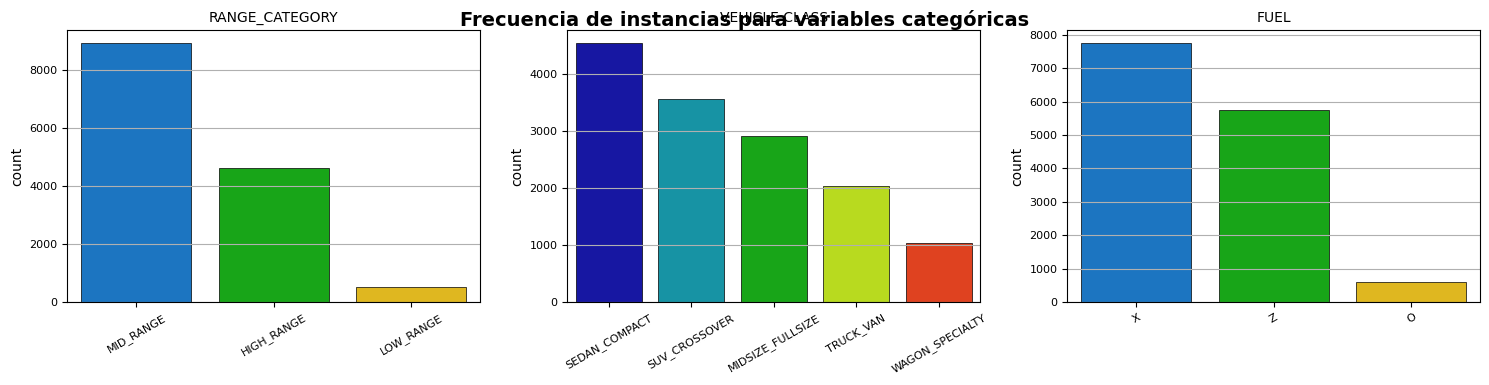

In [7]:
multiple_plot(3, df , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

#### Variables Númericas

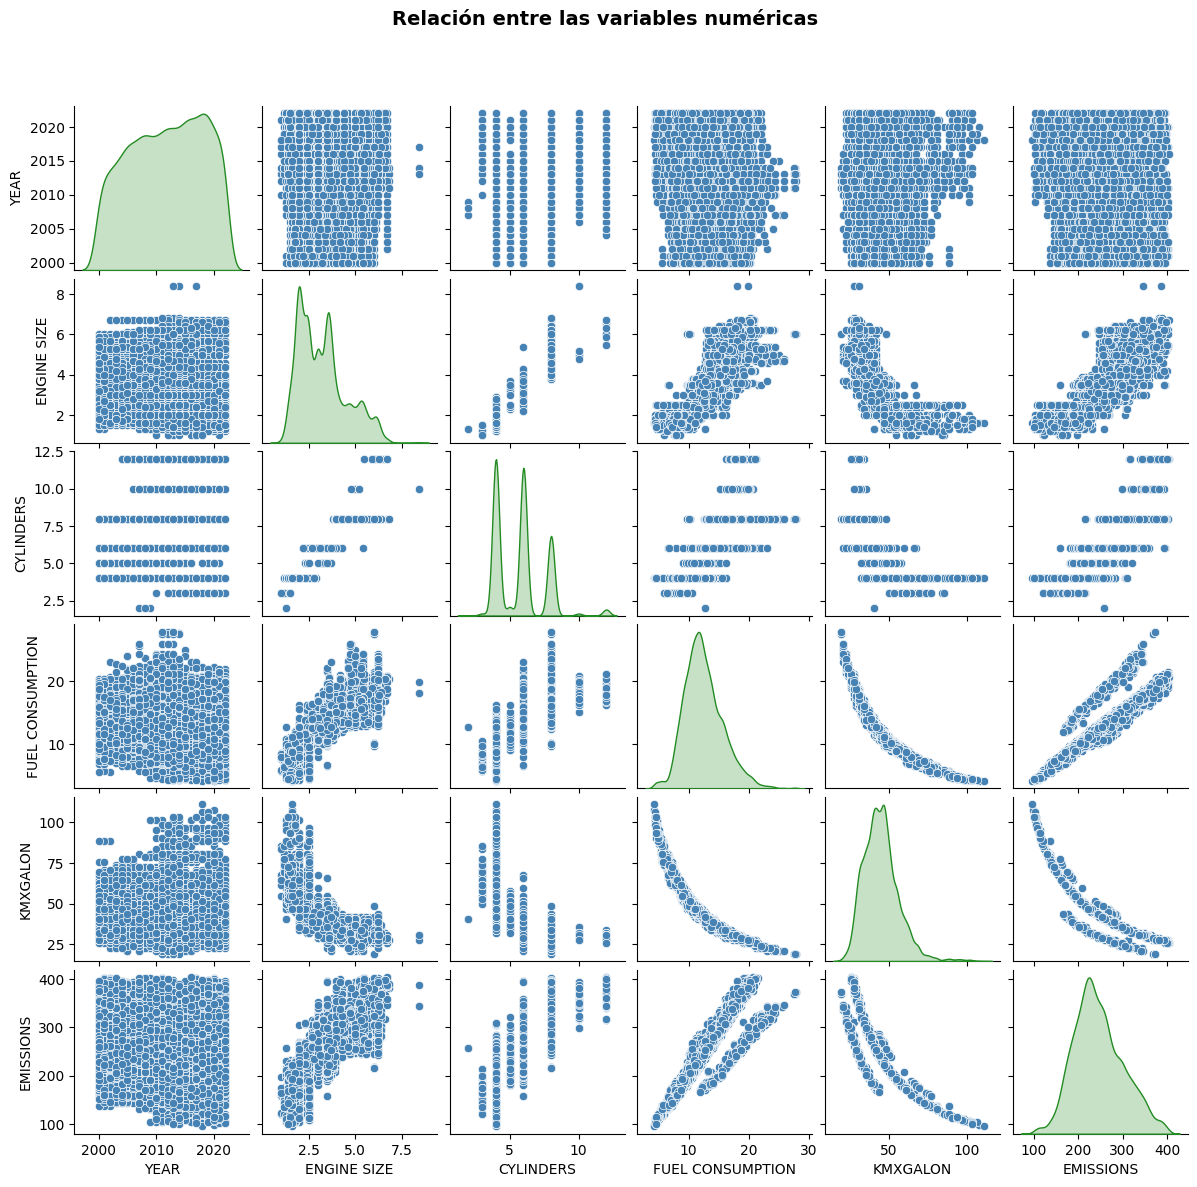

In [8]:
multiple_plot(1, df , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

#### Diagrama distribución de la variable de salida

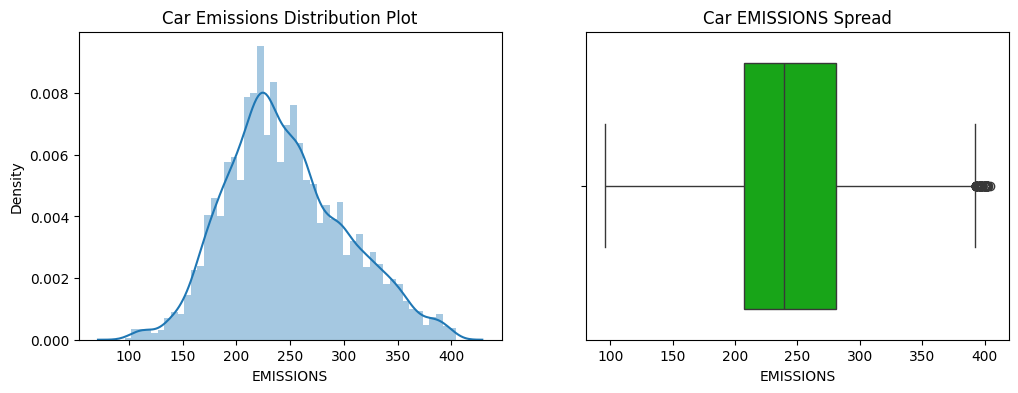

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Emissions Distribution Plot')
sns.distplot(df.EMISSIONS)

plt.subplot(1,2,2)
plt.title('Car EMISSIONS Spread')
sns.boxplot(x=df.EMISSIONS, palette='nipy_spectral')

plt.show()

In [10]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
print(df.EMISSIONS.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count   14093
mean      246
std        56
min        96
25%       207
50%       239
75%       281
85%       308
90%       324
95%       347
97.5%     365
100%      404
max       404
Name: EMISSIONS, dtype: float64


In [11]:
numCols.remove('EMISSIONS')

### Transformación de la variable de salida

Se suele hacer una operación que normalmente es raiz cúbica, se hace con el fin de llevar todos los valores a una distribución normal.

Es importante hacer la operación contraria cuando se evalúe el modelo

In [12]:
#Tranformacion y = y^(1/3) Raiz cúbica
df['EMISSIONS'] = np.cbrt(df['EMISSIONS'])

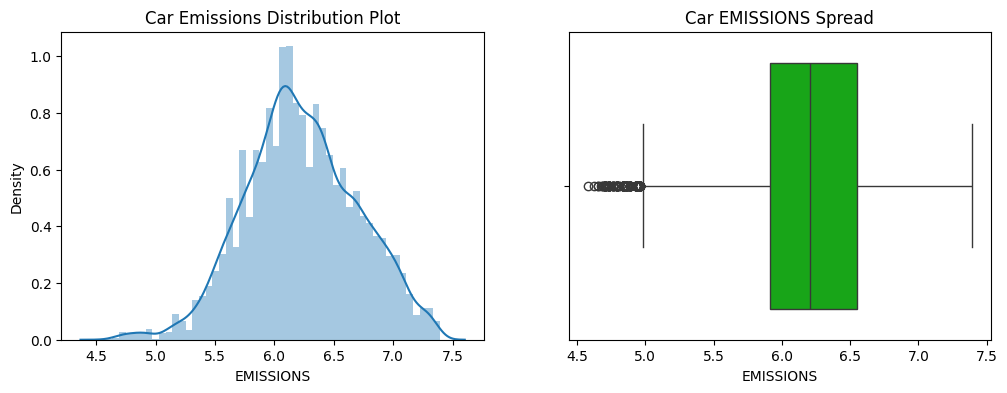

In [13]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Emissions Distribution Plot')
sns.distplot(df.EMISSIONS)

plt.subplot(1,2,2)
plt.title('Car EMISSIONS Spread')
sns.boxplot(x=df.EMISSIONS, palette='nipy_spectral')

plt.show()

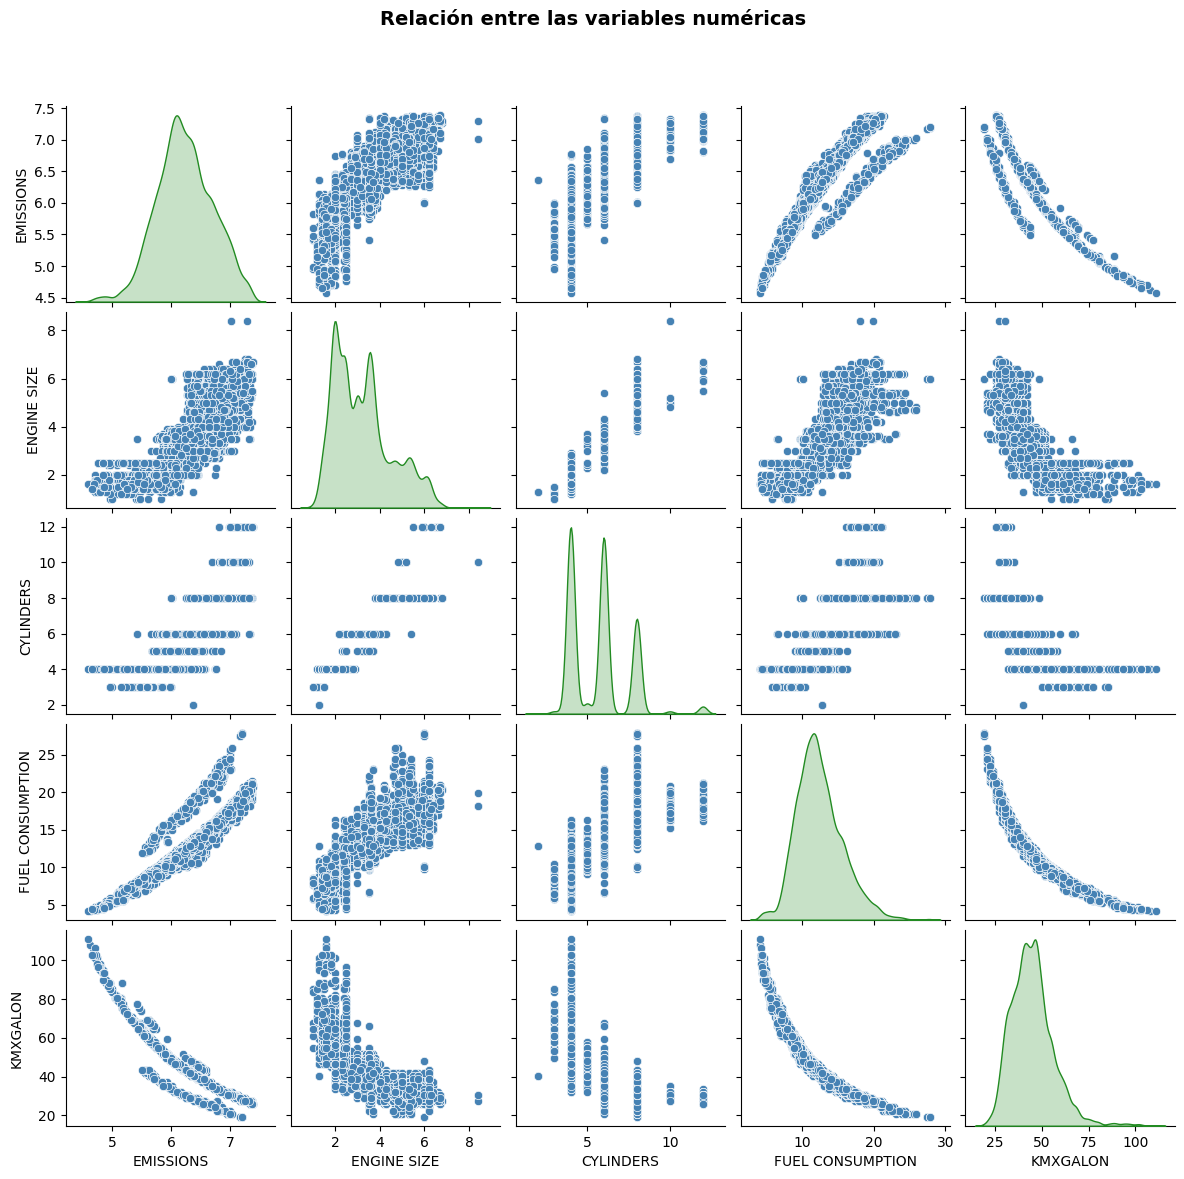

In [14]:
varTrans = ['EMISSIONS','ENGINE SIZE', 'CYLINDERS','FUEL CONSUMPTION','KMXGALON']

multiple_plot(1, df , varTrans, None, 'scatterplot', 'Relación entre las variables numéricas',30)

### Transformación de las variables de entrada

Se hace con el fin de transformar las variables a funciones lineales y tratar de manejarlos bajo la misma escala

In [15]:
#varTrans = ['EMISSIONS','ENGINE SIZE', 'CYLINDERS','FUEL CONSUMPTION','KMXGALON']
df['ENGINE SIZE'] =  np.log(df['ENGINE SIZE'])
df['FUEL CONSUMPTION'] = np.log(df['FUEL CONSUMPTION'])
df['KMXGALON'] = np.log(df['KMXGALON'])

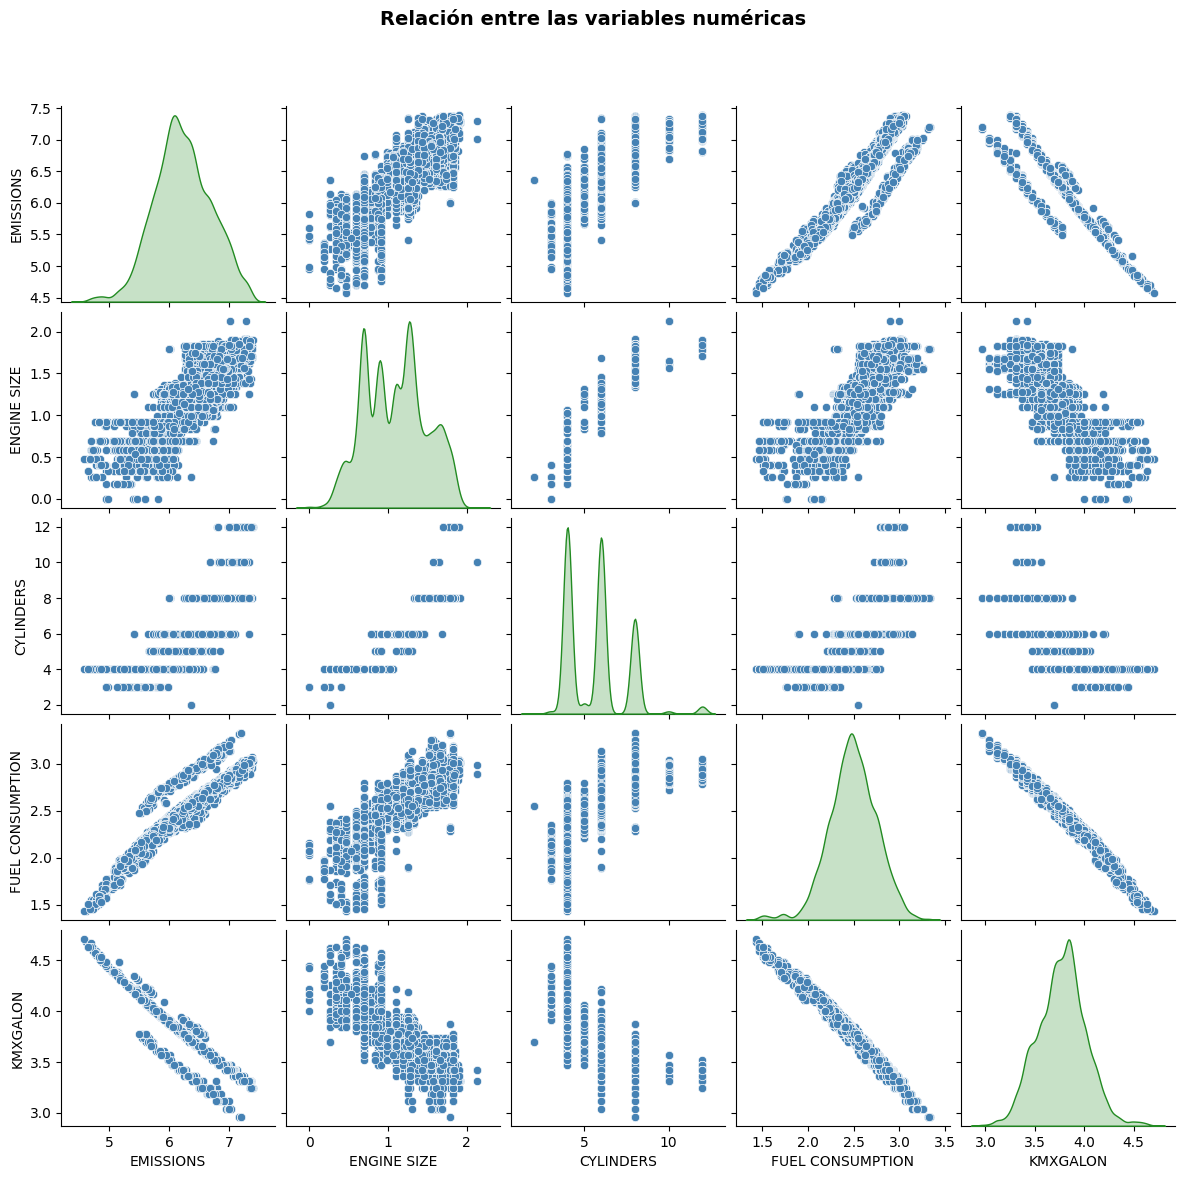

In [16]:
multiple_plot(1, df , varTrans, None, 'scatterplot', 'Relación entre las variables numéricas',30)

### Matriz de correlación

In [17]:
matrizCorr = df[['EMISSIONS']+numCols].corr()

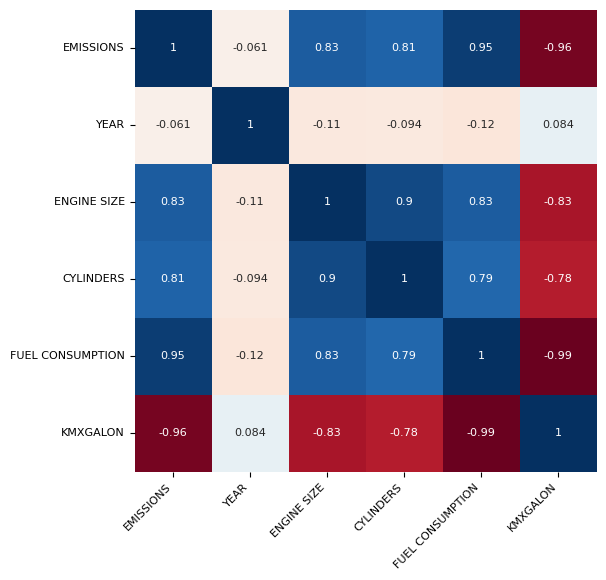

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu',
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)


ax.tick_params(labelsize = 8)


In [19]:
#Matriz de correlación ordenada

pd.set_option('display.float_format', lambda x: '%.4f' % x)

#Creación de la matriz
df_corr= tidy_corr_matrix(matrizCorr)

df_filtrado = df_corr.loc[df_corr['variable_2'] == 'EMISSIONS']

df_filtrado[df_filtrado['abs_r']>=0.5]

,variable_1,variable_2,r,abs_r
30,KMXGALON,EMISSIONS,-0.9586,0.9586
24,FUEL CONSUMPTION,EMISSIONS,0.9497,0.9497
12,ENGINE SIZE,EMISSIONS,0.8334,0.8334
18,CYLINDERS,EMISSIONS,0.8052,0.8052


In [20]:
#Cantidad de variables más relevantes extraidas a partir de la matriz de correlación ordenada
VarRelevantes = df_filtrado[df_filtrado['abs_r']>=0.5].shape[0]

#Creacion de la lista de variables más relevantes (inicialmente numéricas)
vDep =df_filtrado['variable_1'][:VarRelevantes].tolist()
print(vDep)

['KMXGALON', 'FUEL CONSUMPTION', 'ENGINE SIZE', 'CYLINDERS']


In [21]:
df.columns

Index(['YEAR', 'RANGE_CATEGORY', 'VEHICLE CLASS', 'ENGINE SIZE', 'CYLINDERS',
       'FUEL', 'FUEL CONSUMPTION', 'KMXGALON', 'EMISSIONS'],
      dtype='object')

In [22]:
# Se adiiona a la lista de variables numericas más relevantes todas las variables categóricas
vDep += catCols

vDep

['KMXGALON',
 'FUEL CONSUMPTION',
 'ENGINE SIZE',
 'CYLINDERS',
 'RANGE_CATEGORY',
 'VEHICLE CLASS',
 'FUEL']

In [23]:
df = df[vDep  +['EMISSIONS']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14093 entries, 0 to 14092
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   KMXGALON          14093 non-null  float64
 1   FUEL CONSUMPTION  14093 non-null  float64
 2   ENGINE SIZE       14093 non-null  float64
 3   CYLINDERS         14093 non-null  int64  
 4   RANGE_CATEGORY    14093 non-null  object 
 5   VEHICLE CLASS     14093 non-null  object 
 6   FUEL              14093 non-null  object 
 7   EMISSIONS         14093 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 880.9+ KB


### Variables Dummmies

In [24]:
# Aplicación de la función de get_dummies
df = pd.get_dummies(df, dtype=int ,drop_first=1)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14093 entries, 0 to 14092
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   KMXGALON                       14093 non-null  float64
 1   FUEL CONSUMPTION               14093 non-null  float64
 2   ENGINE SIZE                    14093 non-null  float64
 3   CYLINDERS                      14093 non-null  int64  
 4   EMISSIONS                      14093 non-null  float64
 5   RANGE_CATEGORY_LOW_RANGE       14093 non-null  int64  
 6   RANGE_CATEGORY_MID_RANGE       14093 non-null  int64  
 7   VEHICLE CLASS_SEDAN_COMPACT    14093 non-null  int64  
 8   VEHICLE CLASS_SUV_CROSSOVER    14093 non-null  int64  
 9   VEHICLE CLASS_TRUCK_VAN        14093 non-null  int64  
 10  VEHICLE CLASS_WAGON_SPECIALTY  14093 non-null  int64  
 11  FUEL_X                         14093 non-null  int64  
 12  FUEL_Z                         14093 non-null 

In [26]:
#Se crea una lista con todas las varibles de entrada

vDep = list(df.columns)
vDep.remove('EMISSIONS')

#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = df.drop(columns ='EMISSIONS')
y = df['EMISSIONS']

### Separación de los datos entrenamiento y los de prueba

In [27]:
# División de los datos en train y test

#En este caso, el 80% de los datos se utilizarán para entrenar el modelo.

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [28]:
#Se establecen las variables numéricas a escalar

#Num_vars contiene la intersección de variables de las listas numCols y vDep
num_vars = list(set(numCols) & set(vDep))

print(num_vars)

['CYLINDERS', 'ENGINE SIZE', 'FUEL CONSUMPTION', 'KMXGALON']


In [29]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head()

,CYLINDERS,ENGINE SIZE,FUEL CONSUMPTION,KMXGALON
2582,0.4000,0.6148,0.5885,0.4196
2320,0.4000,0.6019,0.5802,0.4844
9633,0.6000,0.7562,0.8347,0.1645
14050,0.2000,0.4838,0.5632,0.4844
10569,0.4000,0.4838,0.6007,0.4420


### Creación del Modelo
#### Colinealidad

In [30]:
checkVIF(X_train)

,Features,VIF
2,ENGINE SIZE,67.6200
1,FUEL CONSUMPTION,48.2600
3,CYLINDERS,36.7700
0,KMXGALON,18.2000
10,FUEL_X,16.5700
11,FUEL_Z,13.3200
5,RANGE_CATEGORY_MID_RANGE,5.8400
6,VEHICLE CLASS_SEDAN_COMPACT,2.7100
7,VEHICLE CLASS_SUV_CROSSOVER,2.4900
8,VEHICLE CLASS_TRUCK_VAN,2.4000


In [31]:
modelo_X_train = build_model(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 2.773e+04
Date:                Sat, 18 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:29:39   Log-Likelihood:                 11650.
No. Observations:               11274   AIC:                        -2.327e+04
Df Residuals:                   11261   BIC:                        -2.318e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [32]:
modelo_X_train = modelo_X_train.drop(["VEHICLE CLASS_WAGON_SPECIALTY"], axis = 1)

In [33]:
checkVIF(modelo_X_train)

,Features,VIF
0,const,3837.1800
1,KMXGALON,73.9900
2,FUEL CONSUMPTION,70.5100
11,FUEL_Z,7.8500
3,ENGINE SIZE,7.5200
10,FUEL_X,7.4500
4,CYLINDERS,6.5400
9,VEHICLE CLASS_TRUCK_VAN,2.2200
6,RANGE_CATEGORY_MID_RANGE,2.1300
8,VEHICLE CLASS_SUV_CROSSOVER,1.8900


In [34]:
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 3.025e+04
Date:                Sat, 18 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:29:39   Log-Likelihood:                 11649.
No. Observations:               11274   AIC:                        -2.327e+04
Df Residuals:                   11262   BIC:                        -2.319e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [35]:
modelo_X_train = modelo_X_train.drop(["VEHICLE CLASS_SEDAN_COMPACT"], axis = 1)

In [36]:
checkVIF(modelo_X_train)

,Features,VIF
0,const,3836.6800
1,KMXGALON,73.8900
2,FUEL CONSUMPTION,70.4300
10,FUEL_Z,7.8000
3,ENGINE SIZE,7.4900
9,FUEL_X,7.4500
4,CYLINDERS,6.5300
6,RANGE_CATEGORY_MID_RANGE,2.1300
8,VEHICLE CLASS_TRUCK_VAN,2.1100
7,VEHICLE CLASS_SUV_CROSSOVER,1.6100


In [37]:
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 3.328e+04
Date:                Sat, 18 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:29:40   Log-Likelihood:                 11649.
No. Observations:               11274   AIC:                        -2.328e+04
Df Residuals:                   11263   BIC:                        -2.319e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [39]:
modelo_X_train = modelo_X_train.drop(["ENGINE SIZE"], axis = 1)

In [40]:
checkVIF(modelo_X_train)

,Features,VIF
0,const,3826.1300
1,KMXGALON,73.7100
2,FUEL CONSUMPTION,68.9900
9,FUEL_Z,7.7700
8,FUEL_X,7.3700
3,CYLINDERS,3.1100
5,RANGE_CATEGORY_MID_RANGE,2.1300
7,VEHICLE CLASS_TRUCK_VAN,2.0600
6,VEHICLE CLASS_SUV_CROSSOVER,1.6000
4,RANGE_CATEGORY_LOW_RANGE,1.2200


In [41]:
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 3.697e+04
Date:                Sat, 18 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:30:18   Log-Likelihood:                 11647.
No. Observations:               11274   AIC:                        -2.327e+04
Df Residuals:                   11264   BIC:                        -2.320e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [42]:
checkVIF(modelo_X_train)

,Features,VIF
0,const,3826.1300
1,KMXGALON,73.7100
2,FUEL CONSUMPTION,68.9900
9,FUEL_Z,7.7700
8,FUEL_X,7.3700
3,CYLINDERS,3.1100
5,RANGE_CATEGORY_MID_RANGE,2.1300
7,VEHICLE CLASS_TRUCK_VAN,2.0600
6,VEHICLE CLASS_SUV_CROSSOVER,1.6000
4,RANGE_CATEGORY_LOW_RANGE,1.2200


In [43]:
modelo_X_train = modelo_X_train.drop(["KMXGALON"], axis = 1)

In [44]:
checkVIF(modelo_X_train)

,Features,VIF
0,const,76.1200
8,FUEL_Z,7.7200
7,FUEL_X,7.2800
1,FUEL CONSUMPTION,3.7300
2,CYLINDERS,3.0900
4,RANGE_CATEGORY_MID_RANGE,2.1200
6,VEHICLE CLASS_TRUCK_VAN,1.7300
5,VEHICLE CLASS_SUV_CROSSOVER,1.3100
3,RANGE_CATEGORY_LOW_RANGE,1.2200


In [45]:
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                 2.949e+04
Date:                Sat, 18 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:30:18   Log-Likelihood:                 9784.1
No. Observations:               11274   AIC:                        -1.955e+04
Df Residuals:                   11265   BIC:                        -1.948e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [46]:
modelLRegresion  = sm.OLS(y_train,modelo_X_train).fit()


### Evaluacion del Modelo

In [47]:
# Diagnóstico errores (residuos) de las predicciones de entrenamiento

#Reducción de dimensionalidad del dataset: se convierte en una dimensión
y_train = y_train.flatten()

#Se realiza la predicción sobre los datos de entrenamiento
prediccion_train = modelLRegresion.predict(modelo_X_train)

#Se calculan los residuos: diferencia entre la prediccion y el valor real en los datos de entreanamiento
residuos_train   = prediccion_train - y_train

In [48]:
# Error de Entrenamiento del modelo


predicciones = modelLRegresion.predict(modelo_X_train)

mse = mean_squared_error (y_true  = y_train, y_pred  = predicciones)
rmse = np.sqrt(mse)
MAE = mean_absolute_error (y_true  = y_train, y_pred  = predicciones)
MedAE = median_absolute_error (y_true  = y_train, y_pred  = predicciones)
r2 = r2_score (y_true  = y_train, y_pred  = predicciones)

print(f"El error MSE   de train es: {mse}")
print(f"El error RMSE  de train es: {rmse}")
print(f"El error MAE   de train es: {MAE}")
print(f"El error MedAE de train es: {MedAE}")
print(f"El error R2    de train es: {r2}")

El error MSE   de train es: 0.010320995167478364
El error RMSE  de train es: 0.10159229876067558
El error MAE   de train es: 0.06887929585514298
El error MedAE de train es: 0.05310036296944176
El error R2    de train es: 0.9544273683788367


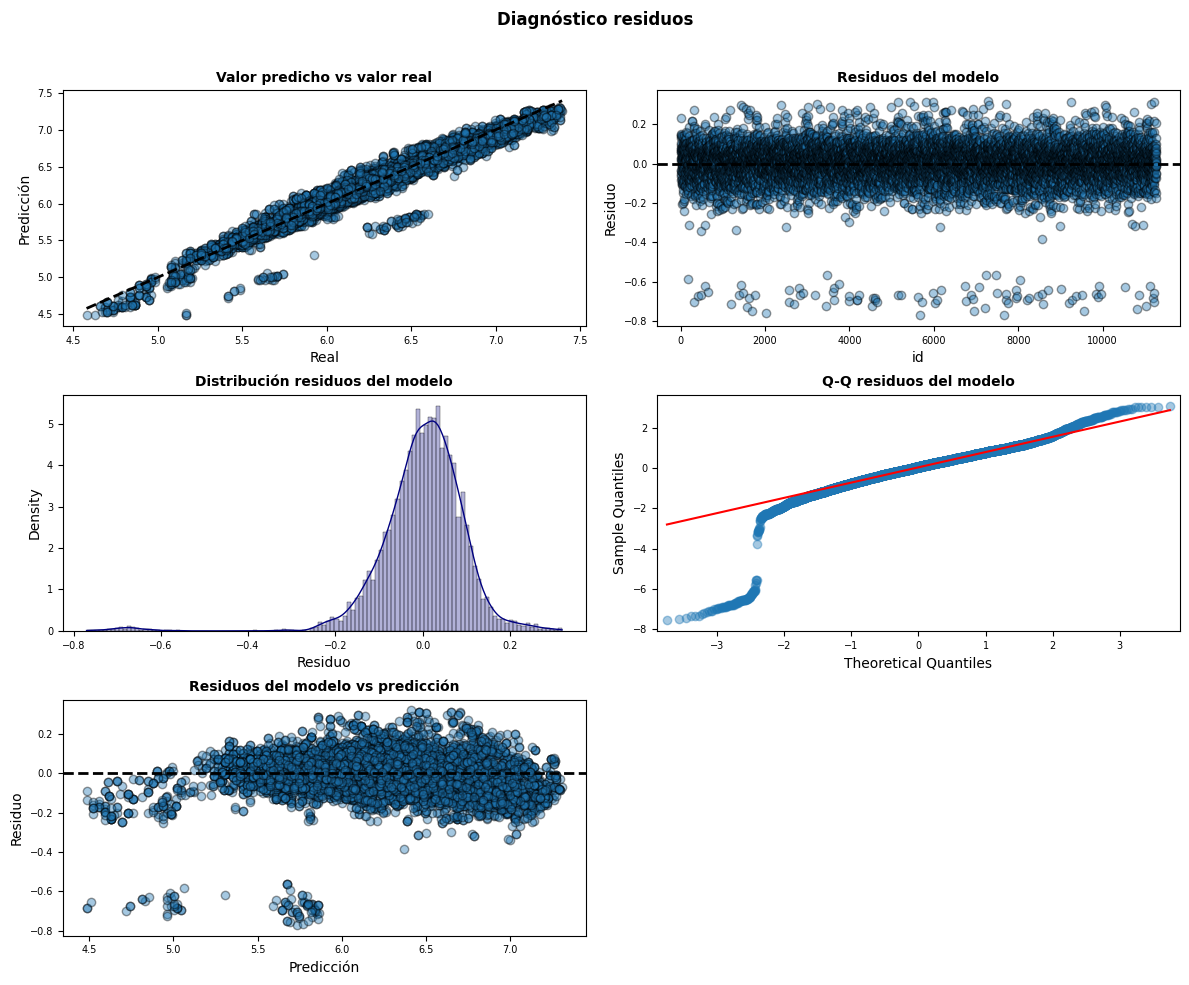

In [49]:
# Gráficos para el pronóstico de residuos

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   =  "navy",#"firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1],
    color = 'navy', #'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [50]:
#Se extraen solo las columnas que finalmente quedaron en X_train (excluyendo constante)
X_test = X_test[modelo_X_train.columns[1:len(modelo_X_train)]]

#Adicionamos la constante
X_test = sm.add_constant(X_test)

In [51]:
# Error de Entrenamiento del modelo


predicciones = modelLRegresion.predict(X_test)

mse = mean_squared_error (y_true  = y_test, y_pred  = predicciones)
rmse = np.sqrt (mse)
MAE = mean_absolute_error (y_true  = y_test, y_pred  = predicciones)
MedAE = median_absolute_error (y_true  = y_test, y_pred  = predicciones)
r2 = r2_score (y_true  = y_test, y_pred  = predicciones)

print(f"El error MSE   de test es: {mse}")
print(f"El error RMSE  de test es: {rmse}")
print(f"El error MAE   de test es: {MAE}")
print(f"El error MedAE de test es: {MedAE}")
print(f"El error R2    de test es: {r2}")

El error MSE   de test es: 0.01178650405049031
El error RMSE  de test es: 0.10856566699693927
El error MAE   de test es: 0.07186187805422993
El error MedAE de test es: 0.05385852959911208
El error R2    de test es: 0.9450969228852844


In [52]:
X_test

,const,FUEL CONSUMPTION,CYLINDERS,RANGE_CATEGORY_LOW_RANGE,RANGE_CATEGORY_MID_RANGE,VEHICLE CLASS_SUV_CROSSOVER,VEHICLE CLASS_TRUCK_VAN,FUEL_X,FUEL_Z
11730,1.0000,0.5717,0.4000,0,0,0,0,0,1
8822,1.0000,0.3966,0.2000,0,1,0,0,1,0
7958,1.0000,0.4686,0.2000,0,0,0,0,0,1
9524,1.0000,0.4988,0.2000,0,1,1,0,1,0
5862,1.0000,0.3336,0.2000,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
13722,1.0000,0.5180,0.4000,0,1,0,0,0,1
10915,1.0000,0.5133,0.4000,0,1,0,0,1,0
4990,1.0000,0.7096,0.4000,0,0,1,0,0,1
510,1.0000,0.4141,0.2000,0,1,0,0,1,0


In [53]:
modelLRegresion.predict(X_test)

11730   6.2779
8822    5.6621
7958    5.9134
9524    6.0690
5862    5.4758
         ...  
13722   6.0979
10915   6.0666
4990    6.7905
510     5.7139
1456    6.5114
Length: 2819, dtype: float64

In [54]:
# Concatenar X_test y y_test
df_prep = pd.DataFrame(np.c_[X_test, y_test], columns= X_test.columns.tolist()+['EMISSIONS'])
df_prep

,const,FUEL CONSUMPTION,CYLINDERS,RANGE_CATEGORY_LOW_RANGE,RANGE_CATEGORY_MID_RANGE,VEHICLE CLASS_SUV_CROSSOVER,VEHICLE CLASS_TRUCK_VAN,FUEL_X,FUEL_Z,EMISSIONS
0,1.0000,0.5717,0.4000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,6.2488
1,1.0000,0.3966,0.2000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,5.6357
2,1.0000,0.4686,0.2000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,5.8088
3,1.0000,0.4988,0.2000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,6.1269
4,1.0000,0.3336,0.2000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,5.4959
...,...,...,...,...,...,...,...,...,...,...
2814,1.0000,0.5180,0.4000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,6.0185
2815,1.0000,0.5133,0.4000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,6.0459
2816,1.0000,0.7096,0.4000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,6.9104
2817,1.0000,0.4141,0.2000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,5.7083


In [55]:
# Predecir los valores para df_prep utilizando el modelLRegresion y Elevar al cubo usando np.power()
resultadoPredict =np.power(modelLRegresion.predict(df_prep.drop(columns ='EMISSIONS')), 3)
resultadoPredict

0      247.4261
1      181.5243
2      206.7841
3      223.5369
4      164.1845
         ...   
2814   226.7438
2815   223.2728
2816   313.1201
2817   186.5554
2818   276.0675
Length: 2819, dtype: float64

In [56]:
# Convertir el array numpy resultadoPredic en un DataFrame de pandas
resultadoPredict_df = pd.DataFrame(resultadoPredict, columns=['EMISSIONS_Predicted'])
resultadoPredict_df

,EMISSIONS_Predicted
0,247.4261
1,181.5243
2,206.7841
3,223.5369
4,164.1845
...,...
2814,226.7438
2815,223.2728
2816,313.1201
2817,186.5554


In [57]:
# Concatenar x_i con el DataFrame de las predicciones
concatenated_df = pd.concat([df_prep.reset_index(drop=True), resultadoPredict_df], axis=1)

# El valor de Y real se eleva al cubo
concatenated_df['EMISSIONS'] = np.power(concatenated_df['EMISSIONS'],3)

In [58]:
# Se calcula el valor absoluto de la diferencia entre el Y real y el Y calculado
concatenated_df['dif'] = (concatenated_df['EMISSIONS'] - concatenated_df['EMISSIONS_Predicted']).abs()

In [69]:
# Las diferencias ordenadas
concatenated_df[['EMISSIONS', 'EMISSIONS_Predicted', 'dif']].sort_values(by='dif', ascending=False)

,EMISSIONS,EMISSIONS_Predicted,dif
1833,279.0000,191.8566,87.1434
114,275.0000,188.4052,86.5948
2800,270.0000,188.4052,81.5948
2274,286.0000,205.1113,80.8887
484,270.0000,190.4730,79.5270
...,...,...,...
2319,242.0000,241.9896,0.0104
2219,242.0000,241.9896,0.0104
2807,233.0000,233.0086,0.0086
1624,237.0000,237.0035,0.0035
